# US Housing Market Analysis

In [2]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
from bokeh.io import export_png
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Loading and cleaning data
We will be using data from [US Housing Market Analysis: Supply-Demand Dynamics](https://www.kaggle.com/datasets/utkarshx27/factors-influence-house-price-in-us) on Kaggle. There are 2 csv files in this dataset: `supply.csv' and `demand.csv`. 

In [3]:
# Read in data
file_path = Path("data/supply.csv")
supply_df = pd.read_csv(file_path)
supply_df.head()

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N
0,01-01-2003,129.321,4.2,1806.333333,421328.6667,14908
1,01-04-2003,131.756,3.833333333,1837.666667,429308.6667,15244
2,01-07-2003,135.013,3.633333333,1937.333333,458890,15614
3,01-10-2003,138.8356667,3.966666667,1972.333333,491437.3333,15654
4,01-01-2004,143.2986667,3.7,1994.666667,506856.3333,15895


In [4]:
# Read in data
file_path = Path("data/demand.csv")
demand_df = pd.read_csv(file_path)
demand_df.head()

,DATE,CSUSHPISA,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,01-01-2003,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,01-04-2003,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,01-07-2003,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,01-10-2003,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,01-01-2004,143.298667,5.597500,98.000000,2.000000,212700,11923.447


In [5]:
# combine data
combined_df = pd.merge(supply_df, demand_df, on="DATE")
combined_df.head()

,DATE,CSUSHPISA_x,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,CSUSHPISA_y,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,01-01-2003,129.321,4.2,1806.333333,421328.6667,14908,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,01-04-2003,131.756,3.833333333,1837.666667,429308.6667,15244,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,01-07-2003,135.013,3.633333333,1937.333333,458890,15614,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,01-10-2003,138.8356667,3.966666667,1972.333333,491437.3333,15654,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,01-01-2004,143.2986667,3.7,1994.666667,506856.3333,15895,143.298667,5.597500,98.000000,2.000000,212700,11923.447


In [6]:
# rename CSUSHPISA_x to CSUSHPISA and drop CSUSHPISA_y
combined_df = combined_df.rename(columns={"CSUSHPISA_x": "CSUSHPISA"})
combined_df = combined_df.drop(columns=["CSUSHPISA_y"])
combined_df.head()

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,01-01-2003,129.321,4.2,1806.333333,421328.6667,14908,5.840769,79.966667,2.250000,186000,11174.129
1,01-04-2003,131.756,3.833333333,1837.666667,429308.6667,15244,5.506923,89.266667,2.166667,191800,11312.766
2,01-07-2003,135.013,3.633333333,1937.333333,458890,15614,6.033846,89.300000,2.000000,191900,11566.669
3,01-10-2003,138.8356667,3.966666667,1972.333333,491437.3333,15654,5.919286,91.966667,2.000000,198800,11772.234
4,01-01-2004,143.2986667,3.7,1994.666667,506856.3333,15895,5.597500,98.000000,2.000000,212700,11923.447


In [7]:
# fill NaN values for INTDSRUSM193N with value from previous row
combined_df["INTDSRUSM193N"] = combined_df["INTDSRUSM193N"].fillna(method="ffill")


In [8]:
combined_df.head()

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,01-01-2003,129.321,4.2,1806.333333,421328.6667,14908,5.840769,79.966667,2.250000,186000,11174.129
1,01-04-2003,131.756,3.833333333,1837.666667,429308.6667,15244,5.506923,89.266667,2.166667,191800,11312.766
2,01-07-2003,135.013,3.633333333,1937.333333,458890,15614,6.033846,89.300000,2.000000,191900,11566.669
3,01-10-2003,138.8356667,3.966666667,1972.333333,491437.3333,15654,5.919286,91.966667,2.000000,198800,11772.234
4,01-01-2004,143.2986667,3.7,1994.666667,506856.3333,15895,5.597500,98.000000,2.000000,212700,11923.447


In [9]:
# replace the value of the last row of the 'CSUSHPISA' column with 294.30366667
combined_df.loc[combined_df.index[-1], "CSUSHPISA"] = "294.30366667"
combined_df.tail()

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
76,01-01-2022,290.868,6.233333333,1864,910611,15166,3.822308,63.133333,0.25,433100,24740.480
77,01-04-2022,303.4226667,8.7,1734.666667,947300.3333,15286,5.266154,57.866667,0.25,449300,25248.476
78,01-07-2022,301.7263333,9.566666667,1610.666667,910346,15306,5.623077,56.100000,0.25,468000,25723.941
79,01-10-2022,297.8966667,9.2,1455.333333,870620.6667,14554,6.664615,58.800000,0.25,479500,26137.992
80,01-01-2023,294.30366667,8.033333333,1424.333333,842559.6667,15053,6.372308,64.633333,0.25,436800,26465.865


In [10]:
# rename the columns
combined_df = combined_df.rename(columns={"DATE": "Date", "CSUSHPISA": "Price Index", "INTDSRUSM193N": "Interest Rate", "MORTGAGE30US": "30-Year Rate Avg", "MSACSR": "Supply", "PERMIT": "Permits", "TLRESCONS": "Construction", "UMCSENT": "Sentiment Index", "MSPUS": "Sales Price", "EVACANTUSQ176N": "Vacancy Rate"})
combined_df.head()

,Date,Price Index,Supply,Permits,Construction,Vacancy Rate,30-Year Rate Avg,Sentiment Index,Interest Rate,Sales Price,GDP
0,01-01-2003,129.321,4.2,1806.333333,421328.6667,14908,5.840769,79.966667,2.250000,186000,11174.129
1,01-04-2003,131.756,3.833333333,1837.666667,429308.6667,15244,5.506923,89.266667,2.166667,191800,11312.766
2,01-07-2003,135.013,3.633333333,1937.333333,458890,15614,6.033846,89.300000,2.000000,191900,11566.669
3,01-10-2003,138.8356667,3.966666667,1972.333333,491437.3333,15654,5.919286,91.966667,2.000000,198800,11772.234
4,01-01-2004,143.2986667,3.7,1994.666667,506856.3333,15895,5.597500,98.000000,2.000000,212700,11923.447


# Defining the feature and target variables

In [11]:
# Define features set
X = combined_df.copy()
X = X.drop("Date", axis=1)
X = X.drop("Price Index", axis=1)
# drop first row
X = X.iloc[1:]
X.head()

,Supply,Permits,Construction,Vacancy Rate,30-Year Rate Avg,Sentiment Index,Interest Rate,Sales Price,GDP
1,3.833333333,1837.666667,429308.6667,15244,5.506923,89.266667,2.166667,191800,11312.766
2,3.633333333,1937.333333,458890,15614,6.033846,89.300000,2.000000,191900,11566.669
3,3.966666667,1972.333333,491437.3333,15654,5.919286,91.966667,2.000000,198800,11772.234
4,3.7,1994.666667,506856.3333,15895,5.597500,98.000000,2.000000,212700,11923.447
5,3.9,2080,526483.3333,16079,6.106154,93.333333,2.083333,217600,12112.815


In [12]:
# checking the shape of X and if there are any null values
print(X.shape)
print(X.isnull().sum())

(80, 9)
Supply              0
Permits             0
Construction        0
Vacancy Rate        0
30-Year Rate Avg    0
Sentiment Index     0
Interest Rate       0
Sales Price         0
GDP                 0
dtype: int64


# Creating the target vector 
Price Index = S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted)

In [13]:
# Define target vector 'PRICE_CHANGE_UP_DOWN' as y
y = combined_df["Price Index"].values.reshape(-1, 1)
y = y[1:]
y[:5]

array([['131.756'],
       ['135.013'],
       ['138.8356667'],
       ['143.2986667'],
       ['148.209']], dtype=object)

# Splitting the data into training and testing sets

In [14]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [15]:
# Create a StandardScaler instance
scaler = StandardScaler()

In [16]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

In [17]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_test_scaled.shape

(20, 9)

# Fitting the Random Forest model

Having scaled the data, we can now fit the Random Forest model to the training data.

In [18]:
# create the random forrest regressor instance
rf_model = RandomForestRegressor(n_estimators=500, random_state=78)
# fit the model
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

# Making predictions with the Random Forest model

In [19]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)
predictions

array([160.09667865, 201.27748998, 157.88526599, 142.69957998,
       167.78128398, 171.867008  , 145.76046468, 171.83385864,
       281.951844  , 198.83965199, 167.98855397, 174.93552532,
       211.90569333, 178.61629531, 148.76067266, 292.41379399,
       149.34653332, 176.04770065, 175.98967132, 159.59784798])

In [20]:
# compare predictions to actual values
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")


First 10 Predictions:   [160.09667865 201.27748998 157.88526599 142.69957998 167.78128398
 171.867008   145.76046468 171.83385864 281.951844   198.83965199]
First 10 Actual labels: [['152.7166667'], ['199.1546667'], ['148.209'], ['140.1133333'], ['175.37'], ['172.9643333'], ['135.013'], ['174.58'], ['290.868'], ['192.6373333']]


# Evaluating the Random Forest model

In [49]:
# chart of predictions vs actual
results_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()})
# change the datatypes to float
results_df = results_df.astype("float64")
# add a column for the difference between the prediction and actual
results_df["Difference"] = results_df["Actual"] - results_df["Prediction"]
# add a column for the percent difference between the prediction and actual
results_df["Percent Difference"] = results_df["Difference"] / results_df["Actual"] * 100
# find the highest percent difference
results_df["Percent Difference"].max()
results_df.tail(10)

,Prediction,Actual,Difference,Percent Difference
10,167.988554,163.481333,-4.507221,-2.757025
11,174.935525,175.695000,0.759475,0.432269
12,211.905693,212.806000,0.900307,0.423065
13,178.616295,179.539333,0.923038,0.514115
14,148.760673,156.028667,7.267994,4.658115
15,292.413794,303.422667,11.008873,3.628230
16,149.346533,148.191000,-1.155533,-0.779759
17,176.047701,181.835667,5.787966,3.183075
18,175.989671,179.422000,3.432329,1.912992
19,159.597848,171.575667,11.977819,6.981071


In [50]:
#use Plotly Express to create a histogram of the percent difference between the actual and predicted values
fig = px.histogram(results_df, x="Percent Difference", title="Percent Difference Between Prediction and Actual")
fig.show()

In [51]:
# save the chart as a png
scope = PlotlyScope()
with open("images/percent_difference_quarterly.png", "wb") as f:
    f.write(scope.transform(fig, format="png"))

In [22]:
# calculate the mean absolute error (MAE)
mae = results_df["Difference"].mean()
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.9014126492088124


In [23]:
# calculate the mean squared error (MSE)
mse = results_df["Difference"].apply(lambda x: x**2).mean()
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 42.287830261386524


In [24]:
# calculate the root mean squared error (RMSE)
rmse = mse**(0.5)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 6.5029093689968125


In [25]:
# calculate the mean absolute percent error (MAPE)
mape = results_df["Percent Difference"].abs().mean()
print(f"Mean Absolute Percent Error: {mape}")


Mean Absolute Percent Error: 3.0161394637161676


In [32]:
# score the model
rf_model.score(X_test_scaled, y_test)

0.9767692621939187

# Feature importance

In [26]:
# get the feature importance array
importances = rf_model.feature_importances_
# list of features
feature_list = list(X.columns)
# sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_list), reverse=True)
# print the feature importance
for feature in zip(feature_list, rf_model.feature_importances_):
    print(f"{feature[0]}: ({feature[1]})")
    

Supply: (0.012806319478155801)
Permits: (0.013968469048040432)
Construction: (0.18056285849011555)
Vacancy Rate: (0.007814080954357346)
30-Year Rate Avg: (0.010012986442315425)
Sentiment Index: (0.012188884699753641)
Interest Rate: (0.12248331576806627)
Sales Price: (0.22164817755412602)
GDP: (0.4185149075650696)


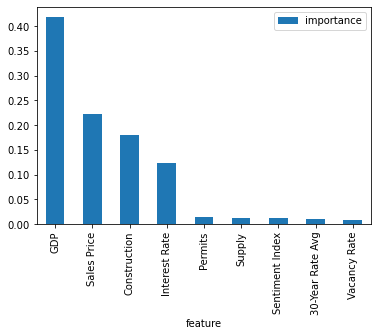

In [27]:
# add the feature importance to a dataframe
feature_importance_df = pd.DataFrame({"feature": feature_list, "importance": importances})
# sort the dataframe by the importance
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# set the index to be the feature
feature_importance_df = feature_importance_df.set_index("feature", drop=True)
# plot the feature importance
feature_importance_df.plot(kind="bar")
plt.show()

In [28]:
# use plotly to create a bar chart of the feature importance
fig = px.bar(feature_importance_df, x=feature_importance_df.index, y="importance", title="Feature Importance", color="importance", color_continuous_scale=px.colors.sequential.Cividis_r)
# save the graph
fig.write_image("images/feature_importance_quarterly.png")
# show the graph
fig.show()

In [29]:
# define a function to output images of tables
def save_df_as_image(df, filename):
    source = ColumnDataSource(df)
    columns = [TableColumn(field=Ci, title=Ci) for Ci in df.columns]  # bokeh columns
    # add index column
    columns.insert(0, TableColumn(field="index", title="index"))
    # use df index as index column
    source.add(df.index, "index")
    data_table = DataTable(columns=columns, source=source, width=800, height=280)
    export_png(data_table, filename=filename)

In [30]:
# save a table of the feature importance
save_df_as_image(feature_importance_df, "images/feature_importance_quarterly_table.png")